# Understanding Multi-Agent Deep Deterministic Policy Gradient (MADDPG): A Complete Guide

# Table of Contents

- [Introduction: Multi-Agent Reinforcement Learning (MARL)](#introduction)
- [The Challenge of Non-Stationarity in MARL](#challenge-non-stationarity)
- [What is MADDPG?](#what-is-maddpg)
  - [Core Idea: Centralized Training, Decentralized Execution](#core-idea)
- [Why MADDPG? Advantages](#why-maddpg)
- [Where and How MADDPG is Used](#where-and-how-maddpg-is-used)
- [Mathematical Foundation of MADDPG](#mathematical-foundation-of-maddpg)
  - [Centralized Action-Value Function (Critic)](#centralized-action-value-function-critic)
  - [Critic Update](#critic-update)
  - [Actor Update (Policy Gradient)](#actor-update-policy-gradient)
  - [Target Networks and Soft Updates](#target-networks-and-soft-updates)
  - [Exploration](#exploration)
- [Step-by-Step Explanation of MADDPG](#step-by-step-explanation-of-maddpg)
- [Key Components of MADDPG](#key-components-of-maddpg)
  - [Per-Agent Actor Networks](#per-agent-actor-networks)
  - [Per-Agent Centralized Critic Networks](#per-agent-centralized-critic-networks)
  - [Target Networks (Actors & Critics)](#target-networks-actors--critics)
  - [Replay Buffer (Shared)](#replay-buffer-shared)
  - [Action Selection & Exploration](#action-selection--exploration)
  - [Centralized Training Logic](#centralized-training-logic)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Multi-Agent Grid World](#practical-example-custom-multi-agent-grid-world)
  - [Environment Design Rationale](#environment-design-rationale)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Multi-Agent Environment](#creating-the-custom-multi-agent-environment)
- [Implementing the MADDPG Algorithm](#implementing-the-maddpg-algorithm)
  - [Defining the Actor Network (Discrete Actions)](#defining-the-actor-network-discrete-actions)
  - [Defining the Centralized Critic Network](#defining-the-centralized-critic-network)
  - [Defining the Replay Memory](#defining-the-replay-memory)
  - [Soft Update Function](#soft-update-function)
  - [MADDPG Agent Manager Class](#maddpg-agent-manager-class)
  - [The MADDPG Update Step](#the-maddpg-update-step)
- [Running the MADDPG Algorithm](#running-the-maddpg-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policies (Testing)](#analyzing-the-learned-policies-testing)
- [Common Challenges and Extensions of MADDPG](#common-challenges-and-extensions-of-maddpg)
- [Conclusion](#conclusion)

## Introduction: Multi-Agent Reinforcement Learning (MARL)

Multi-Agent Reinforcement Learning (MARL) extends RL to scenarios with multiple agents interacting within a shared environment. These agents might cooperate, compete, or have mixed objectives. MARL introduces unique challenges not present in single-agent settings.

## The Challenge of Non-Stationarity in MARL

A major difficulty arises when multiple agents learn simultaneously. From the perspective of any single agent, the environment appears *non-stationary* because the other agents' policies are constantly changing as they learn. An action that was good when other agents behaved one way might become bad when they adapt. This violates the stationarity assumption underlying many single-agent RL algorithms like standard Q-learning or DDPG, making learning unstable.

## What is MADDPG?

Multi-Agent Deep Deterministic Policy Gradient (MADDPG) is an extension of the DDPG algorithm designed to address the non-stationarity problem in multi-agent settings. It utilizes the paradigm of **centralized training with decentralized execution**.

### Core Idea: Centralized Training, Decentralized Execution

1.  **Decentralized Execution:** During execution (acting in the environment), each agent $i$ selects its action $a_i$ based only on its *local* observation $o_i$ using its own actor network $\mu_i(o_i; \theta_i)$. This is crucial for practical deployment where agents might not have access to global information.
2.  **Centralized Training:** During the training phase (updating the networks), MADDPG utilizes a *centralized critic* $Q_i$ for each agent $i$. This critic takes the *joint* observations (or states) of *all* agents ($x = (o_1, ..., o_N)$) and the *joint* actions of *all* agents ($a = (a_1, ..., a_N)$) as input to estimate the action-value $Q_i(x, a_1, ..., a_N; \phi_i)$.

By conditioning the critic on the joint state and actions, the learning target for each agent becomes stationary, even as other agents' policies change, because the critic knows what actions the other agents *actually took* (during training). This stabilizes the learning process.

## Why MADDPG? Advantages

- **Handles Non-Stationarity:** The centralized critic mitigates the primary challenge of multi-agent learning.
- **Uses Only Local Information for Execution:** Policies can be deployed in scenarios where agents only have partial observability.
- **No Assumptions on Environment Structure:** Unlike some MARL methods, it doesn't require specific communication protocols or knowledge of the reward structure (e.g., difference rewards).
- **Handles Cooperative, Competitive, or Mixed Settings:** The framework is general.

## Where and How MADDPG is Used

MADDPG has been applied to various multi-agent domains:

1.  **Cooperative Navigation:** Multiple agents coordinating to reach target locations while avoiding collisions.
2.  **Predator-Prey Scenarios:** Agents learning to pursue or evade others.
3.  **Traffic Signal Control:** Coordinating traffic lights.
4.  **Multi-Robot Coordination:** Task allocation and path planning.

It is particularly suitable when:
- Agents have continuous or discrete action spaces (though originally presented for continuous).
- Centralized training is feasible (access to joint information during learning phase).
- Decentralized execution is required.
- The environment dynamics are complex and potentially non-stationary from a single agent's view.

## Mathematical Foundation of MADDPG

MADDPG extends the DDPG framework to $N$ agents. Let the policies be $\boldsymbol{\mu} = \{\mu_1, ..., \mu_N\}$ parameterized by $\boldsymbol{\theta} = \{\theta_1, ..., \theta_N\}$, and the centralized action-value functions be $Q_i(x, a_1, ..., a_N; \phi_i)$ parameterized by $\phi_i$ for each agent $i$.

### Centralized Action-Value Function (Critic)
Each agent $i$ learns its own critic $Q_i(x, a_1, ..., a_N)$, where $x=(o_1, ..., o_N)$ represents the joint observations (or full state if available). This function estimates the expected return for *agent i*, given the joint context and actions.

### Critic Update
The critic $Q_i(x, a_1, ..., a_N; \phi_i)$ for each agent $i$ is updated by minimizing the loss using samples from a shared replay buffer $\mathcal{D}$. The loss is typically MSE:
$$ L(\phi_i) = \mathbb{E}_{(x, a, r, x') \sim \mathcal{D}} [ (y_i - Q_i(x, a_1, ..., a_N; \phi_i))^2 ] $$
The target value $y_i$ is calculated using the *target* networks (denoted with a prime):
$$ y_i = r_i + \gamma Q'_i(x', a'_1, ..., a'_N; \phi'_i)|_{a'_j = \mu'_j(o'_j)} $$
where $a'_j = \mu'_j(o'_j; \theta'_j)$ are the next actions predicted by each agent's *target* actor network based on their *next* local observations $o'_j$ from $x'$.

### Actor Update (Policy Gradient)
The actor $\mu_i(o_i; \theta_i)$ for each agent $i$ is updated using the deterministic policy gradient theorem, adapted for the centralized critic. The gradient ascent direction for actor $i$ is:
$$ \nabla_{\theta_i} J(\theta_i) \approx \mathbb{E}_{x, a \sim \mathcal{D}} [ \nabla_{\theta_i} \mu_i(o_i; \theta_i) \nabla_{a_i} Q_i(x, a_1, ..., a_N; \phi_i)|_{a_i=\mu_i(o_i)} ] $$
In practice, using PyTorch autograd, this is often achieved by minimizing the loss:
$$ L(\theta_i) = - \mathbb{E}_{o_i \sim \mathcal{D}} [ Q_i(x, \mu_1(o_1), ..., \mu_N(o_N); \phi_i) ] $$
When calculating this loss and its gradient for actor $i$, the observations $o_j$ and actions $a_j = \mu_j(o_j)$ for $j \neq i$ are treated as fixed inputs obtained from the buffer or current policies.

*Adaptation for Discrete Actions:* If using discrete actions, the actor typically outputs logits for a probability distribution (e.g., Categorical or Gumbel-Softmax). The update can then use a policy gradient approach where the advantage is derived from the centralized critic $Q_i$. For simplicity, one might use $Q_i(x, a_1, ..., a_N)$ directly as the signal (similar to how DDPG uses Q) to push up the probability of the action taken if the Q-value is high, although more sophisticated policy gradient estimates involving baselines are possible.

### Target Networks and Soft Updates
Similar to DDPG, MADDPG uses target networks for all actors ($\mu'_i$) and critics ($Q'_i$), updated via soft updates:
$$ \theta'_i \leftarrow \tau \theta_i + (1 - \tau) \theta'_i $$
$$\phi'_i \leftarrow \tau \phi_i + (1 - \tau) \phi'_i $$

### Exploration
Exploration is typically handled by adding noise to the actions output by the deterministic actors during training rollouts. This is usually done independently for each agent (e.g., independent Ornstein-Uhlenbeck or Gaussian noise processes).
For our discrete action adaptation, exploration can be achieved by sampling from the actor's output distribution or using $\epsilon$-greedy based on the actor's preferred action.

## Step-by-Step Explanation of MADDPG

1.  **Initialize**: For each agent $i=1...N$:
    - Actor network $\mu_i(\theta_i)$, Critic network $Q_i(\phi_i)$.
    - Target networks $\mu'_i(\theta'_i)$, $Q'_i(\phi'_i)$ with $\theta'_i \leftarrow \theta_i, \phi'_i \leftarrow \phi_i$.
    - Exploration noise process $\mathcal{N}_i$.
2.  **Initialize**: Shared Replay buffer $\mathcal{D}$.
3.  **For each training episode**:
    a.  Get initial joint state/observations $x = (o_1, ..., o_N)$. Reset noise processes.
    b.  **For each step $t$**:
        i.   For each agent $i$, select action $a_i = \mu_i(o_i; \theta_i) + \mathcal{N}_i$. Clip action if necessary.
        ii.  Execute joint action $a = (a_1, ..., a_N)$, observe joint reward $r=(r_1, ..., r_N)$ and next joint state/observations $x'=(o'_1, ..., o'_N)$, and done flags $d=(d_1, ..., d_N)$.
        iii. Store the *joint* transition $(x, a, r, x', d)$ in $\mathcal{D}$.
        iv.  $x \leftarrow x'$.
        v.   **Update Step (if buffer has enough samples)**:
            1.  Sample a random mini-batch of $B$ joint transitions from $\mathcal{D}$.
            2.  For each agent $i=1...N$:
                - **Update Critic $Q_i$**: Compute target $y_i$ using target networks $\mu'_j, Q'_i$. Minimize $L(\phi_i)$.
                - **Update Actor $\mu_i$**: Minimize actor loss $L(\theta_i)$ using the main centralized critic $Q_i$. 
            3.  For each agent $i=1...N$:
                - **Update Target Networks**: Perform soft updates on $\theta'_i$ and $\phi'_i$.
        vi.  If any agent is done (or global termination), break step loop.
4.  **Repeat**: Until convergence.

## Key Components of MADDPG

### Per-Agent Actor Networks
- Each agent $i$ has an actor $\mu_i$ mapping its local observation $o_i$ to its action $a_i$.
- Trained using gradients from its associated centralized critic.

### Per-Agent Centralized Critic Networks
- Each agent $i$ has a critic $Q_i$ that estimates agent $i$'s action-value based on *joint* observations and *joint* actions $(x, a_1, ..., a_N)$.
- Trained using target values derived from target networks.

### Target Networks (Actors & Critics)
- Slow-updating copies of all actor and critic networks used for stable target calculation.

### Replay Buffer (Shared)
- Stores tuples of joint experience: $(x, a, r, x', d)$.
- Enables off-policy learning.

### Action Selection & Exploration
- Actors are used decentrally for execution, based only on local $o_i$.
- Exploration noise (or sampling strategy) is added independently per agent during training.

### Centralized Training Logic
- The update step requires access to all agents' network parameters (for targets and critic inputs) and data from the shared buffer.

### Hyperparameters
- Similar to DDPG (buffer size, batch size, learning rates, $\tau$, $\gamma$, noise params), but potentially needed per agent or shared.

## Practical Example: Custom Multi-Agent Grid World

### Environment Design Rationale
We'll create a simple 2-agent cooperative navigation task on a grid:
- **State:** Positions of both agents and positions of their respective targets.
- **Observation (Agent $i$):** Agent $i$'s position, Agent $i$'s target position, Other agent's position.
- **Actions:** Discrete (Up, Down, Left, Right) for each agent.
- **Reward:** Cooperative. Small negative reward per step. Large positive reward if *both* agents are simultaneously at their targets. Maybe a shaped reward based on distance reduction.
- **Goal:** Both agents reach their targets concurrently.

This allows us to demonstrate centralized Q-value estimation based on joint state (all positions) and joint actions, while actors act on local observations. We adapt MADDPG for discrete actions using policy gradients guided by the centralized Q-critic.

# Setting up the Environment

Import libraries.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable, Any
import copy

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical # For discrete actor

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cpu


# Creating the Custom Multi-Agent Environment

A simple 2-agent cooperative grid navigation task.

In [2]:
class MultiAgentGridEnv:
    """
    Simple 2-Agent Cooperative Grid World.
    Agents must reach their respective goals simultaneously.
    Observation includes agent positions and goal positions.
    Rewards are shared.
    """
    def __init__(self, size: int = 5, num_agents: int = 2):
        self.size: int = size
        self.num_agents: int = num_agents
        self.action_dim: int = 4 # U, D, L, R
        self.action_map: Dict[int, Tuple[int, int]] = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
        self.actions: List[int] = list(self.action_map.keys())

        # Define fixed start and goal positions for simplicity
        self.start_positions: List[Tuple[int, int]] = [(0, 0), (size - 1, size - 1)]
        self.goal_positions: List[Tuple[int, int]] = [(size - 1, 0), (0, size - 1)]
        if num_agents != 2:
             raise NotImplementedError("Currently supports only 2 agents.")

        self.agent_positions: List[Tuple[int, int]] = list(self.start_positions)

        # Observation space for agent i: (self_r, self_c, other_r, other_c, goal_i_r, goal_i_c)
        # Normalized between 0 and 1
        self.observation_dim_per_agent: int = 6 
        self.max_coord = float(self.size - 1)

    def _normalize_pos(self, pos: Tuple[int, int]) -> Tuple[float, float]:
        """ Normalizes a grid position. """
        r, c = pos
        return (r / self.max_coord, c / self.max_coord) if self.max_coord > 0 else (0.0, 0.0)
        
    def _get_observation(self, agent_id: int) -> np.ndarray:
        """ Get normalized local observation for a specific agent. """
        obs = []
        # Self position
        self_pos_norm = self._normalize_pos(self.agent_positions[agent_id])
        obs.extend(self_pos_norm)
        # Other agent position
        other_id = 1 - agent_id
        other_pos_norm = self._normalize_pos(self.agent_positions[other_id])
        obs.extend(other_pos_norm)
        # Self goal position
        goal_pos_norm = self._normalize_pos(self.goal_positions[agent_id])
        obs.extend(goal_pos_norm)
        return np.array(obs, dtype=np.float32)

    def get_joint_observation(self) -> List[np.ndarray]:
        """ Get list of observations for all agents. """
        return [self._get_observation(i) for i in range(self.num_agents)]
        
    def reset(self) -> List[np.ndarray]:
        """ Resets environment, returns list of initial observations. """
        self.agent_positions = list(self.start_positions)
        return self.get_joint_observation()

    def step(self, actions: List[int]) -> Tuple[List[np.ndarray], List[float], bool]:
        """
        Performs one step for all agents.
        
        Parameters:
        - actions (List[int]): List of actions, one for each agent.
        
        Returns:
        - Tuple[List[np.ndarray], List[float], bool]: 
            - List of next observations for each agent.
            - List of rewards for each agent (shared reward).
            - Global done flag.
        """
        if len(actions) != self.num_agents:
            raise ValueError(f"Expected {self.num_agents} actions, got {len(actions)}")
            
        next_positions: List[Tuple[int, int]] = list(self.agent_positions) # Start with current
        total_dist_reduction = 0.0
        hit_wall_penalty = 0.0

        for i in range(self.num_agents):
            current_pos = self.agent_positions[i]
            if current_pos == self.goal_positions[i]: # Agent already at goal, doesn't move
                continue 
                
            action = actions[i]
            dr, dc = self.action_map[action]
            next_r, next_c = current_pos[0] + dr, current_pos[1] + dc
            
            # Check bounds and update position
            if 0 <= next_r < self.size and 0 <= next_c < self.size:
                next_positions[i] = (next_r, next_c)
            else:
                hit_wall_penalty -= 0.5 # Penalty for hitting wall
                next_positions[i] = current_pos # Stay in place
                
        # Simple collision handling: if agents move to same spot, they bounce back
        if self.num_agents == 2 and next_positions[0] == next_positions[1]:
            next_positions = list(self.agent_positions) # Revert to previous positions
            hit_wall_penalty -= 0.5 # Treat as a penalty (like hitting a wall)
            
        self.agent_positions = next_positions

        # Calculate reward and done flag
        done = all(self.agent_positions[i] == self.goal_positions[i] for i in range(self.num_agents))
        
        if done:
            reward = 10.0 # Large reward for cooperative success
        else:
            # Distance-based reward (negative sum of distances to goals)
            dist_reward = 0.0
            for i in range(self.num_agents):
                dist = abs(self.agent_positions[i][0] - self.goal_positions[i][0]) + \
                       abs(self.agent_positions[i][1] - self.goal_positions[i][1])
                dist_reward -= dist * 0.1 # Scaled negative distance
            
            reward = -0.05 + dist_reward + hit_wall_penalty # Small step penalty + distance + wall penalty

        next_observations = self.get_joint_observation()
        # Shared reward
        rewards = [reward] * self.num_agents 
        
        return next_observations, rewards, done

Instantiate and test the multi-agent environment.

In [3]:
maddpg_env = MultiAgentGridEnv(size=5, num_agents=2)
initial_obs_list = maddpg_env.reset()
print(f"MADDPG Env Size: {maddpg_env.size}x{maddpg_env.size}")
print(f"Num Agents: {maddpg_env.num_agents}")
print(f"Action Dim per Agent: {maddpg_env.action_dim}")
print(f"Obs Dim per Agent: {maddpg_env.observation_dim_per_agent}")
print(f"Agent 0 Initial Obs: {initial_obs_list[0]}")
print(f"Agent 1 Initial Obs: {initial_obs_list[1]}")

# Example step
actions_example = [1, 2] # Agent 0 Down, Agent 1 Left
next_obs_list, rewards_list, done_flag = maddpg_env.step(actions_example)
print(f"\nAfter actions {actions_example}:")
print(f" Agent 0 Next Obs: {next_obs_list[0]}")
print(f" Agent 1 Next Obs: {next_obs_list[1]}")
print(f" Shared Reward: {rewards_list[0]}")
print(f" Done: {done_flag}")

MADDPG Env Size: 5x5
Num Agents: 2
Action Dim per Agent: 4
Obs Dim per Agent: 6
Agent 0 Initial Obs: [0. 0. 1. 1. 1. 0.]
Agent 1 Initial Obs: [1. 1. 0. 0. 0. 1.]

After actions [1, 2]:
 Agent 0 Next Obs: [0.25 0.   1.   0.75 1.   0.  ]
 Agent 1 Next Obs: [1.   0.75 0.25 0.   0.   1.  ]
 Shared Reward: -0.8500000000000001
 Done: False


# Implementing the MADDPG Algorithm

### Defining the Actor Network (Discrete Actions)

Outputs logits for a Categorical distribution over discrete actions.

In [4]:
class ActorDiscrete(nn.Module):
    """ Actor Network for discrete actions in MADDPG. """
    def __init__(self, obs_dim: int, action_dim: int):
        super(ActorDiscrete, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, obs: torch.Tensor) -> Categorical:
        """ Maps observation to action logits -> Categorical distribution. """
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        action_logits = self.fc3(x)
        return Categorical(logits=action_logits)
        
    def select_action(self, obs: torch.Tensor, use_exploration=True) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Selects action based on policy (sampling or argmax). """
        dist = self.forward(obs)
        if use_exploration:
            action = dist.sample()
        else: # Deterministic for testing or target action prediction
            action = torch.argmax(dist.probs, dim=-1)
        log_prob = dist.log_prob(action)
        return action, log_prob

### Defining the Centralized Critic Network

Takes joint observations and joint actions as input.

In [5]:
class CentralizedCritic(nn.Module):
    """ Centralized Critic Network for MADDPG. """
    def __init__(self, joint_obs_dim: int, joint_action_dim: int):
        super(CentralizedCritic, self).__init__()
        # Input size = size of all obs + size of all actions
        self.fc1 = nn.Linear(joint_obs_dim + joint_action_dim, 256) 
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1) # Output single Q-value for a specific agent

    def forward(self, joint_obs: torch.Tensor, joint_actions: torch.Tensor) -> torch.Tensor:
        """ Maps joint observations and actions to a Q-value. """
        # Ensure actions are in the correct format (e.g., one-hot for discrete)
        # For simplicity here, we might pass action indices and handle inside or assume
        # they are already processed (e.g., continuous or embedded).
        # Let's assume actions are concatenated directly for simplicity here.
        x = torch.cat([joint_obs, joint_actions], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

### Defining the Replay Memory

Stores joint transitions.

In [6]:
# Define transition structure for MADDPG buffer
# Storing individual agent components separately is often easier for batching
Experience = namedtuple('Experience', 
                        ('obs_list', 'action_list', 'reward_list', 
                         'next_obs_list', 'done_list'))

# Replay Buffer (modified to handle lists of agent data)
class MultiAgentReplayBuffer:
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def push(self, obs_list: List[np.ndarray], action_list: List[int], 
               reward_list: List[float], next_obs_list: List[np.ndarray], 
               done: bool) -> None:
        """ Saves a joint transition. """
        # Convert numpy arrays to tensors (or store as numpy)
        # Storing numpy might be slightly more memory efficient before batching
        obs_t = [torch.from_numpy(o).float() for o in obs_list]
        act_t = torch.tensor(action_list, dtype=torch.long) # Store action indices
        rew_t = torch.tensor(reward_list, dtype=torch.float32)
        next_obs_t = [torch.from_numpy(o).float() for o in next_obs_list]
        done_t = torch.tensor([float(done)] * len(obs_list), dtype=torch.float32) # Repeat done flag for each agent
        
        self.memory.append(Experience(obs_t, act_t, rew_t, next_obs_t, done_t))

    def sample(self, batch_size: int) -> Optional[Experience]:
        """ Samples a batch of experiences. """
        if len(self.memory) < batch_size:
            return None
        
        experiences = random.sample(self.memory, batch_size)
        
        # Batch processing: stack tensors for each component across the batch and agents
        # Resulting shapes need careful handling in the update step
        obs_batch, act_batch, rew_batch, next_obs_batch, dones_batch = zip(*experiences)
        
        # Example: Stack observations -> (batch_size, num_agents, obs_dim)
        obs_batch_stacked = torch.stack([torch.stack(obs) for obs in obs_batch])
        act_batch_stacked = torch.stack(act_batch) # (batch_size, num_agents)
        rew_batch_stacked = torch.stack(rew_batch) # (batch_size, num_agents)
        next_obs_batch_stacked = torch.stack([torch.stack(n_obs) for n_obs in next_obs_batch])
        dones_batch_stacked = torch.stack(dones_batch) # (batch_size, num_agents)
        
        # Return a named tuple with batched tensors
        return Experience(obs_batch_stacked, act_batch_stacked, rew_batch_stacked, 
                          next_obs_batch_stacked, dones_batch_stacked)

    def __len__(self) -> int:
        return len(self.memory)

### Soft Update Function

Standard soft update.

In [7]:
def soft_update(target_net: nn.Module, main_net: nn.Module, tau: float) -> None:
    for target_param, main_param in zip(target_net.parameters(), main_net.parameters()):
        target_param.data.copy_(tau * main_param.data + (1.0 - tau) * target_param.data)

### MADDPG Agent Manager Class

A class to manage the collection of agents, their networks, and optimizers.

In [8]:
class MADDPGAgentManager:
    """ Manages multiple agents, their networks, and updates for MADDPG. """
    def __init__(self, num_agents: int, obs_dim_list: List[int], action_dim: int,
                 actor_lr: float, critic_lr: float, gamma: float, tau: float,
                 device: torch.device):
        
        self.num_agents = num_agents
        self.obs_dim_list = obs_dim_list
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.device = device

        # Calculate joint dimensions needed for critic
        joint_obs_dim = sum(obs_dim_list)
        # For discrete actions, critic needs appropriate representation (e.g., one-hot or indices)
        # If passing indices, need embedding or careful handling. If one-hot, dim is num_agents * action_dim.
        # Let's pass one-hot encoded actions to the critic.
        joint_action_dim_one_hot = num_agents * action_dim

        self.actors: List[ActorDiscrete] = []
        self.critics: List[CentralizedCritic] = []
        self.target_actors: List[ActorDiscrete] = []
        self.target_critics: List[CentralizedCritic] = []
        self.actor_optimizers: List[optim.Optimizer] = []
        self.critic_optimizers: List[optim.Optimizer] = []

        for i in range(num_agents):
            # Create networks for agent i
            actor = ActorDiscrete(obs_dim_list[i], action_dim).to(device)
            critic = CentralizedCritic(joint_obs_dim, joint_action_dim_one_hot).to(device)
            target_actor = ActorDiscrete(obs_dim_list[i], action_dim).to(device)
            target_critic = CentralizedCritic(joint_obs_dim, joint_action_dim_one_hot).to(device)

            # Initialize target networks
            target_actor.load_state_dict(actor.state_dict())
            target_critic.load_state_dict(critic.state_dict())
            for p in target_actor.parameters(): p.requires_grad = False
            for p in target_critic.parameters(): p.requires_grad = False

            # Create optimizers
            actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
            critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
            
            # Store agent components
            self.actors.append(actor)
            self.critics.append(critic)
            self.target_actors.append(target_actor)
            self.target_critics.append(target_critic)
            self.actor_optimizers.append(actor_optimizer)
            self.critic_optimizers.append(critic_optimizer)

    def select_actions(self, obs_list: List[torch.Tensor], use_exploration=True) -> Tuple[List[int], List[torch.Tensor]]:
        """ Select actions for all agents based on their local observations. """
        actions = []
        log_probs = [] 
        for i in range(self.num_agents):
            self.actors[i].eval()
            with torch.no_grad():
                act, log_prob = self.actors[i].select_action(obs_list[i].to(self.device), use_exploration)
                # Convert to scalar if it's a single observation
                if act.dim() == 0:
                    act = act.item()
            self.actors[i].train()
            actions.append(act)
            log_probs.append(log_prob)
        return actions, log_probs

    def update(self, batch: Experience, agent_id: int) -> Tuple[float, float]:
        """ Perform update for a single agent 'agent_id'. """
        # Unpack batch data
        # Shapes: obs/next_obs(B, N, O_dim), acts(B, N),rews(B, N), dones(B, N)
        obs_batch, act_batch, rew_batch, next_obs_batch, dones_batch = batch
        batch_size = obs_batch.shape[0]

        # Prepare inputs for the centralized critic
        # Concatenate observations: (B, N, O) -> (B, N*O)
        joint_obs = obs_batch.view(batch_size, -1).to(self.device)
        joint_next_obs = next_obs_batch.view(batch_size, -1).to(self.device)

        # Convert action indices to one-hot encoding for critic input
        act_one_hot = F.one_hot(act_batch, num_classes=self.action_dim).float()
        joint_actions_one_hot = act_one_hot.view(batch_size, -1).to(self.device)
        
        # Get rewards and dones for the current agent
        rewards_i = rew_batch[:, agent_id].unsqueeze(-1).to(self.device)
        dones_i = dones_batch[:, agent_id].unsqueeze(-1).to(self.device)
        
        # --- Critic Update --- 
        with torch.no_grad():
            # Get next actions from ALL target actors
            target_next_actions_list = []
            for j in range(self.num_agents):
                # Input: next observation for agent j across the batch (B, O_j)
                obs_j_next = next_obs_batch[:, j, :].to(self.device)
                # Get deterministic action from target actor j
                action_j_next, _ = self.target_actors[j].select_action(obs_j_next, use_exploration=False)
                # Convert action index to one-hot
                action_j_next_one_hot = F.one_hot(action_j_next, num_classes=self.action_dim).float()
                target_next_actions_list.append(action_j_next_one_hot)
                
            # Concatenate target next actions: (B, N*A_onehot)
            joint_target_next_actions = torch.cat(target_next_actions_list, dim=1).to(self.device)

            # Get target Q value from target critic i
            q_target_next = self.target_critics[agent_id](joint_next_obs, joint_target_next_actions)
            
            # Calculate target y = r_i + gamma * Q'_i * (1 - d_i)
            y = rewards_i + self.gamma * (1.0 - dones_i) * q_target_next

        # Get current Q estimate from main critic i
        q_current = self.critics[agent_id](joint_obs, joint_actions_one_hot)
        
        # Compute Critic loss
        critic_loss = F.mse_loss(q_current, y)

        # Optimize Critic i
        self.critic_optimizers[agent_id].zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critics[agent_id].parameters(), 1.0) # Optional clipping
        self.critic_optimizers[agent_id].step()

        # --- Actor Update --- 
        # Freeze critic gradients for actor update
        for p in self.critics[agent_id].parameters():
            p.requires_grad = False

        # Calculate actions for ALL agents using their CURRENT actors based on batch obs
        current_actions_list = []
        log_probs_i_list = [] # Store log_prob for agent i only
        for j in range(self.num_agents):
            obs_j = obs_batch[:, j, :].to(self.device)
            # Need action probabilities/logits for the update - use Gumbel-Softmax or REINFORCE-like update
            dist_j = self.actors[j](obs_j) # Get Categorical distribution
            # If we use DDPG objective: Q(s, mu(s)), we need deterministic actions
            # Let's adapt using policy gradient: Maximize E[log_pi_i * Q_i_detached]
            action_j = dist_j.sample() # Sample action for input to Q
            if j == agent_id:
                 log_prob_i = dist_j.log_prob(action_j) # Only need log_prob for the agent being updated

            action_j_one_hot = F.one_hot(action_j, num_classes=self.action_dim).float()
            current_actions_list.append(action_j_one_hot)
            
        joint_current_actions = torch.cat(current_actions_list, dim=1).to(self.device)

        # Calculate Actor loss: - E[log_pi_i * Q_i_detached]
        # Q_i is evaluated with the *current* actions from all actors
        q_for_actor_loss = self.critics[agent_id](joint_obs, joint_current_actions)
        actor_loss = -(log_prob_i * q_for_actor_loss.detach()).mean() # Detach Q value 
        
        # Alternative DDPG-style loss (if actors were deterministic): 
        # actor_loss = -self.critics[agent_id](joint_obs, joint_current_actions).mean()
        
        # Optimize Actor i
        self.actor_optimizers[agent_id].zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actors[agent_id].parameters(), 1.0) # Optional clipping
        self.actor_optimizers[agent_id].step()
        
        # Unfreeze critic gradients
        for p in self.critics[agent_id].parameters():
            p.requires_grad = True
            
        return critic_loss.item(), actor_loss.item()

    def update_targets(self) -> None:
        """ Perform soft updates for all target networks. """
        for i in range(self.num_agents):
            soft_update(self.target_critics[i], self.critics[i], self.tau)
            soft_update(self.target_actors[i], self.actors[i], self.tau)

# Running the MADDPG Algorithm

### Hyperparameter Setup

In [9]:
# Hyperparameters for MADDPG on Custom Multi-Agent Grid World
BUFFER_SIZE_MADDPG = int(1e5)
BATCH_SIZE_MADDPG = 256
GAMMA_MADDPG = 0.99
TAU_MADDPG = 1e-3
ACTOR_LR_MADDPG = 1e-4
CRITIC_LR_MADDPG = 1e-3
EPSILON_MADDPG_START = 1.0 # For epsilon-greedy exploration with discrete actions
EPSILON_MADDPG_END = 0.05
EPSILON_MADDPG_DECAY = 50000 # Decay over this many steps

NUM_EPISODES_MADDPG = 200
MAX_STEPS_PER_EPISODE_MADDPG = 100
UPDATE_EVERY_MADDPG = 4      # Perform update every N environment steps
NUM_UPDATES_MADDPG = 1       # Number of update passes per update interval

### Initialization

In [10]:
# Initialize Environment
env_maddpg = MultiAgentGridEnv(size=5, num_agents=2)
num_agents = env_maddpg.num_agents
obs_dims = [env_maddpg.observation_dim_per_agent] * num_agents
action_dim = env_maddpg.action_dim

# Initialize Agent Manager
maddpg_manager = MADDPGAgentManager(
    num_agents=num_agents,
    obs_dim_list=obs_dims,
    action_dim=action_dim,
    actor_lr=ACTOR_LR_MADDPG,
    critic_lr=CRITIC_LR_MADDPG,
    gamma=GAMMA_MADDPG,
    tau=TAU_MADDPG,
    device=device
)

# Initialize Replay Buffer
memory_maddpg = MultiAgentReplayBuffer(BUFFER_SIZE_MADDPG)

# Lists for plotting
maddpg_episode_rewards = [] # Store total reward per episode (sum over agents)
maddpg_critic_losses = [[] for _ in range(num_agents)] # List of lists for each agent's critic loss
maddpg_actor_losses = [[] for _ in range(num_agents)] # List of lists for each agent's actor loss

### Training Loop

In [11]:
print("Starting MADDPG Training...")

total_steps_maddpg = 0
epsilon = EPSILON_MADDPG_START

for i_episode in range(1, NUM_EPISODES_MADDPG + 1):
    obs_list_np = env_maddpg.reset()
    obs_list = [torch.from_numpy(o).float().to(device) for o in obs_list_np]
    episode_reward = 0
    ep_critic_losses = [0.0] * num_agents
    ep_actor_losses = [0.0] * num_agents
    num_updates_ep = 0

    for t in range(MAX_STEPS_PER_EPISODE_MADDPG):
        # --- Action Selection --- 
        # Use epsilon-greedy for discrete actions adaptation
        if random.random() < epsilon:
            actions_list = [random.randrange(action_dim) for _ in range(num_agents)]
        else:
            # Get actions from actors (use_exploration=False gives argmax for testing)
            actions_list, _ = maddpg_manager.select_actions(obs_list, use_exploration=False)
        
        # --- Environment Interaction --- 
        next_obs_list_np, rewards_list, done = env_maddpg.step(actions_list)
        
        # --- Store Experience (Joint) --- 
        memory_maddpg.push(obs_list_np, actions_list, rewards_list, next_obs_list_np, done)

        # Update state representations
        obs_list_np = next_obs_list_np
        obs_list = [torch.from_numpy(o).float().to(device) for o in obs_list_np]
        
        # Accumulate shared reward for logging
        episode_reward += rewards_list[0] # Using agent 0's reward as the shared reward
        total_steps_maddpg += 1

        # --- Update Networks --- 
        if len(memory_maddpg) > BATCH_SIZE_MADDPG and total_steps_maddpg % UPDATE_EVERY_MADDPG == 0:
            for _ in range(NUM_UPDATES_MADDPG):
                batch = memory_maddpg.sample(BATCH_SIZE_MADDPG)
                if batch:
                    for agent_id in range(num_agents):
                        c_loss, a_loss = maddpg_manager.update(batch, agent_id)
                        ep_critic_losses[agent_id] += c_loss
                        ep_actor_losses[agent_id] += a_loss
                    num_updates_ep += 1
                    # Update target networks after updating all agents
                    maddpg_manager.update_targets()

        # Decay epsilon
        epsilon = max(EPSILON_MADDPG_END, EPSILON_MADDPG_START - total_steps_maddpg / EPSILON_MADDPG_DECAY * (EPSILON_MADDPG_START - EPSILON_MADDPG_END))

        if done:
            break
            
    # --- End of Episode --- 
    maddpg_episode_rewards.append(episode_reward)
    for i in range(num_agents):
        maddpg_critic_losses[i].append(ep_critic_losses[i] / num_updates_ep if num_updates_ep > 0 else 0)
        maddpg_actor_losses[i].append(ep_actor_losses[i] / num_updates_ep if num_updates_ep > 0 else 0)
    
    # Print progress
    if i_episode % 50 == 0:
        avg_reward = np.mean(maddpg_episode_rewards[-50:])
        avg_closs = np.mean([np.mean(maddpg_critic_losses[i][-50:]) for i in range(num_agents)])
        avg_aloss = np.mean([np.mean(maddpg_actor_losses[i][-50:]) for i in range(num_agents)])
        print(f"Ep {i_episode}/{NUM_EPISODES_MADDPG} | Steps: {total_steps_maddpg} | Avg Reward: {avg_reward:.2f} | Avg C_Loss: {avg_closs:.4f} | Avg A_Loss: {avg_aloss:.4f} | Eps: {epsilon:.3f}")

print("Training Finished (MADDPG).")

Starting MADDPG Training...
Ep 50/200 | Steps: 4130 | Avg Reward: -65.08 | Avg C_Loss: 0.1754 | Avg A_Loss: -1.5070 | Eps: 0.922
Ep 100/200 | Steps: 7739 | Avg Reward: -57.36 | Avg C_Loss: 0.0337 | Avg A_Loss: -2.1525 | Eps: 0.853
Ep 150/200 | Steps: 11024 | Avg Reward: -47.13 | Avg C_Loss: 0.0143 | Avg A_Loss: -2.8037 | Eps: 0.791
Ep 200/200 | Steps: 14686 | Avg Reward: -54.68 | Avg C_Loss: 0.0153 | Avg A_Loss: -3.7225 | Eps: 0.721
Training Finished (MADDPG).


# Visualizing the Learning Process

Plot aggregate episode rewards and average losses across agents.

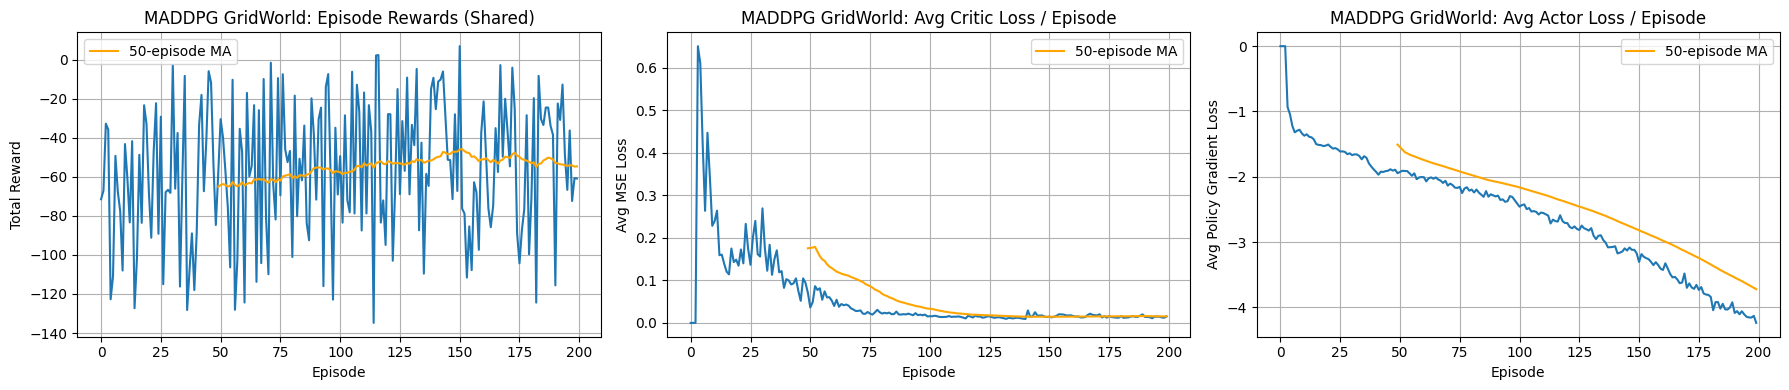

In [12]:
# Plotting results for MADDPG
plt.figure(figsize=(18, 4))

# Episode Rewards (Aggregate)
plt.subplot(1, 3, 1)
plt.plot(maddpg_episode_rewards)
plt.title('MADDPG GridWorld: Episode Rewards (Shared)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
if len(maddpg_episode_rewards) >= 50:
    rewards_ma_maddpg = np.convolve(maddpg_episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(rewards_ma_maddpg)) + 49, rewards_ma_maddpg, label='50-episode MA', color='orange')
    plt.legend()

# Average Critic Loss (Across Agents)
avg_critic_losses = np.mean(maddpg_critic_losses, axis=0)
plt.subplot(1, 3, 2)
plt.plot(avg_critic_losses)
plt.title('MADDPG GridWorld: Avg Critic Loss / Episode')
plt.xlabel('Episode')
plt.ylabel('Avg MSE Loss')
plt.grid(True)
if len(avg_critic_losses) >= 50:
    closs_ma_maddpg = np.convolve(avg_critic_losses, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(closs_ma_maddpg)) + 49, closs_ma_maddpg, label='50-episode MA', color='orange')
    plt.legend()

# Average Actor Loss (Across Agents)
avg_actor_losses = np.mean(maddpg_actor_losses, axis=0)
plt.subplot(1, 3, 3)
plt.plot(avg_actor_losses)
plt.title('MADDPG GridWorld: Avg Actor Loss / Episode')
plt.xlabel('Episode')
plt.ylabel('Avg Policy Gradient Loss')
plt.grid(True)
if len(avg_actor_losses) >= 50:
    aloss_ma_maddpg = np.convolve(avg_actor_losses, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(aloss_ma_maddpg)) + 49, aloss_ma_maddpg, label='50-episode MA', color='orange')
    plt.legend()

plt.tight_layout()
plt.show()

**Analysis of MADDPG Learning Curves (GridWorld - Shared Reward):**

1.  **Episode Rewards (Shared):**
    *   **Observation:** The total shared reward per episode exhibits extreme volatility throughout the entire training period (200 episodes). While the 50-episode moving average (orange line) suggests a slight, gradual upward trend, indicating some learning is occurring, it remains significantly negative (hovering around -50 towards the end) and far from any potential optimal value (which would likely be positive in a goal-reaching task). There are large swings in performance from one episode to the next, without clear signs of stabilizing at a high reward level.
    *   **Interpretation:** This plot highlights the primary challenge encountered: achieving stable and effective cooperative behavior. The high variance suggests that the decentralized actors are struggling to consistently coordinate their actions to achieve the shared goal. While the moving average shows *some* improvement over purely random behavior, the lack of convergence to high rewards indicates that finding a robust, cooperative joint policy is difficult under these conditions. The learning process is unstable, characteristic of the complexities introduced by multiple interacting agents.

2.  **Avg Critic Loss / Episode:**
    *   **Observation:** In stark contrast to the rewards, the average Mean Squared Error (MSE) loss for the centralized critic shows excellent convergence properties. After some initial high spikes (likely due to random initial policies and large prediction errors), the loss drops dramatically within the first ~50 episodes and converges steadily towards zero, remaining very low for the rest of the training.
    *   **Interpretation:** This indicates that the centralized critic, which observes the actions and states of all agents, is effectively learning to predict the expected shared return (Q-value) for joint state-action pairs. The rapid convergence to low loss suggests the value estimation component of MADDPG is functioning well and is capable of accurately evaluating the consequences of the agents' collective actions based on the data it receives.

3.  **Avg Actor Loss / Episode:**
    *   **Observation:** The average actor loss, representing the policy gradient objective (often related to the Q-value estimated by the critic for the actor's chosen action), displays a clear and consistent downward trend (becoming more negative). This indicates that, on average, the actors are successfully adjusting their policies in directions that the critic suggests will lead to higher expected returns.
    *   **Interpretation:** This plot confirms that the policy update mechanism is working as intended. Each decentralized actor is using the gradient information provided by the centralized critic to improve its individual policy. The steady decrease implies consistent policy improvement *according to the critic's current estimate*.

**Overall Conclusion:**
The MADDPG results present an interesting picture common in multi-agent learning. The underlying mechanisms – the centralized critic learning value functions and the decentralized actors updating policies based on critic guidance – appear to be functioning correctly, as shown by the converging loss plots. However, this internal learning progress does not translate into stable, high-reward team performance. The extreme volatility in shared rewards suggests significant challenges in coordination, credit assignment, or dealing with the non-stationary environment (where each agent's policy changes affect the optimal policy for others). While the critic learns *what* good joint actions look like, the decentralized actors struggle to consistently *discover and execute* those coordinated actions, leading to unstable overall results within the observed training duration.

# Analyzing the Learned Policies (Testing)

Test the agents acting decentrally using their learned actors.

In [13]:
def test_maddpg_agents(manager: MADDPGAgentManager, 
                         env_instance: MultiAgentGridEnv, 
                         num_episodes: int = 5, 
                         seed_offset: int = 5000) -> None:
    """ Tests the trained MADDPG agents acting decentrally. """
    print(f"\n--- Testing MADDPG Agents ({num_episodes} episodes) ---")
    all_episode_rewards = []

    for i in range(num_episodes):
        obs_list_np = env_instance.reset() # Use internal seeding if env supports it
        obs_list = [torch.from_numpy(o).float().to(manager.device) for o in obs_list_np]
        episode_reward = 0
        done = False
        t = 0

        while not done and t < MAX_STEPS_PER_EPISODE_MADDPG: # Add step limit for testing
            # Get actions decentrally, without exploration noise
            actions_list, _ = maddpg_manager.select_actions(obs_list, use_exploration=True)
            
            # Step environment
            next_obs_list_np, rewards_list, done = env_instance.step(actions_list)
            
            # Update observations
            obs_list = [torch.from_numpy(o).float().to(manager.device) for o in next_obs_list_np]
            
            episode_reward += rewards_list[0] # Track shared reward
            t += 1
            
        print(f"Test Episode {i+1}: Reward = {episode_reward:.2f}, Length = {t}")
        all_episode_rewards.append(episode_reward)

    print(f"--- Testing Complete. Average Reward: {np.mean(all_episode_rewards):.2f} ---")

# Run test episodes
test_maddpg_agents(maddpg_manager, env_maddpg, num_episodes=5)


--- Testing MADDPG Agents (5 episodes) ---
Test Episode 1: Reward = -78.40, Length = 100
Test Episode 2: Reward = -119.80, Length = 100
Test Episode 3: Reward = -88.30, Length = 100
Test Episode 4: Reward = -35.60, Length = 53
Test Episode 5: Reward = -80.10, Length = 100
--- Testing Complete. Average Reward: -80.44 ---


## Common Challenges and Extensions of MADDPG

**Challenge: Scalability of Centralized Critic**
*   **Problem:** The input dimension of the centralized critic grows linearly with the number of agents (joint observations + joint actions). This can become computationally infeasible for a very large number of agents.
*   **Solutions**:
    *   **Parameter Sharing:** Use shared network parameters across critics (or actors) for similar agents.
    *   **Attention Mechanisms:** Use attention to focus the critic on relevant information from other agents.
    *   **Approximations:** Use methods that approximate the centralized critic without requiring full joint information (e.g., mean-field approaches).

**Challenge: Credit Assignment in Cooperative Settings**
*   **Problem:** When using a shared team reward, it's hard for an individual agent's critic to determine that agent's specific contribution to the team's success (the credit assignment problem).
   **Solutions**:
    *   **Counterfactual Baselines (COMA):** Compare the current joint Q-value with a baseline where only the current agent's action is varied.
    *   **Value Decomposition Networks (VDN, QMIX):** Learn individual agent Q-functions that combine (e.g., sum) to form the joint Q-function, enforcing a relationship useful for credit assignment.

**Challenge: Sensitivity to Hyperparameters**
*   **Problem:** Like DDPG, MADDPG can be sensitive to learning rates, target updates, exploration noise, buffer size, etc.
   **Solution:** Careful tuning is required, often specific to the MARL problem.

**Challenge: Continuous Action Space Issues**
*   **Problem:** The original MADDPG inherits potential instability issues from DDPG in continuous action spaces (e.g., Q-value overestimation).
   **Solution:** Incorporate ideas from TD3 (e.g., twin centralized critics, delayed policy updates, target action smoothing) into the MADDPG framework (resulting in MATD3).

**Extensions:**
- **MATD3:** Incorporates TD3 improvements into MADDPG.
- **MAPPO:** Adapts PPO for multi-agent settings, often using a centralized value function.
- **Value Decomposition Methods (VDN, QMIX):** Focus on cooperative tasks with shared rewards.

## Conclusion

MADDPG provides an effective framework for applying deep actor-critic methods to multi-agent environments. By leveraging centralized training (specifically through a centralized critic aware of joint information) and decentralized execution (actors using local observations), it successfully mitigates the non-stationarity challenge inherent in MARL.

Its ability to handle various agent interactions (cooperative, competitive, mixed) and action spaces makes it a versatile algorithm. While challenges remain, particularly concerning scalability to very large numbers of agents and robust credit assignment, MADDPG represents a significant step in MARL and serves as a foundation for many subsequent multi-agent algorithms.